In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.mlocation_scatter2 as mlocation_scatter

from mlgrad import averager_it

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = True

In [2]:
def permutate_values(Yp, Y, m):
    d = {}
    for yp,y in zip(Yp, Y):
        c = d.setdefault((yp,y), 0)
        d[(yp,y)] = c+1
    print(d)
    values = np.array(list(d.values()))
    keys = list(d.keys())
    indices = list(np.argsort(values))
    keys = [keys[indices[-i]] for i in range(1,m+1)]
    print(keys)
    d = dict(keys)
    for i in range(len(Y)):
        yp = Yp[i]
        Yp[i] = d[yp]

In [3]:
sdata = pd.read_csv("data/cbb/s4.txt", names=['x1', 'x2'], sep='\s+')

In [4]:
X = np.c_[sdata['x1'], sdata['x2']]
X = np.ascontiguousarray(X, 'd')
X = scale(X) * 10
print(len(X))
print(X)

5000
[[ 7.29059268 19.62055749]
 [10.227693   13.72893773]
 [ 8.66905768 10.36587057]
 ...
 [ 3.97718727 13.90313587]
 [-3.50564265 21.9961753 ]
 [-4.13857942 18.28724732]]


In [5]:
x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()
x_min = min(x1_min, x2_min)
x_max = max(x1_max, x2_max)
extent = (x_min, x_max, x_min, x_max)
xrange1 = np.linspace(x_min, x_max, 100)
xrange2 = np.linspace(x_min, x_max, 100)
XX1, XX2, = np.meshgrid(xrange1, xrange2)
XX = np.c_[XX1.ravel(), XX2.ravel()]

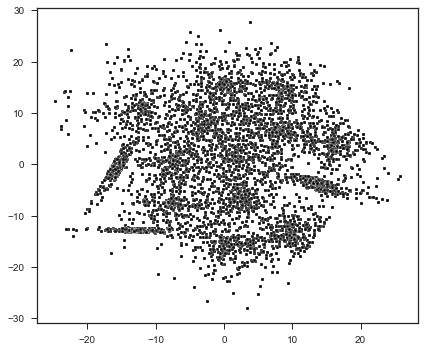

In [6]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.show()

In [18]:
# avgmin = avragg.SoftMinimal(2.0)
avgmin = avragg.Minimal()
avrfunc = averager_it(func.QuantileFunc(0.95, func.Sqrt(0.001)))
# avrfunc = averager_it(func.QuantileFunc(0.94, func.Power(1.01, 0.001)))
avrfunc = avragg.ParameterizedAverage(func.WinsorizedSmoothFunc(func.Sqrt(0.001)), avrfunc)
hcd = mlocation_scatter.MLocationsScattersEstimator(avrfunc, avgmin, 15, 
                                    tol=1.0e-6, n_iter=200, n_step=400)

In [19]:
# hcd.fit(X, only='locations')
hcd.fit(X)

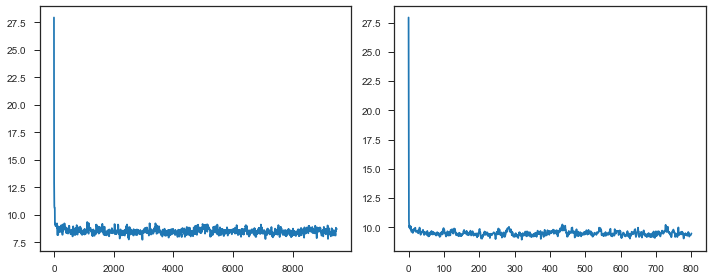

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hcd.dvals)
plt.subplot(1,2,2)
plt.plot(hcd.dvals2)
plt.show()

In [21]:
D = hcd.evaluate_dist(XX)
DD = D.reshape(XX1.shape)
print(D.min(), D.max())

0.001319121010047042 830.1647932346164


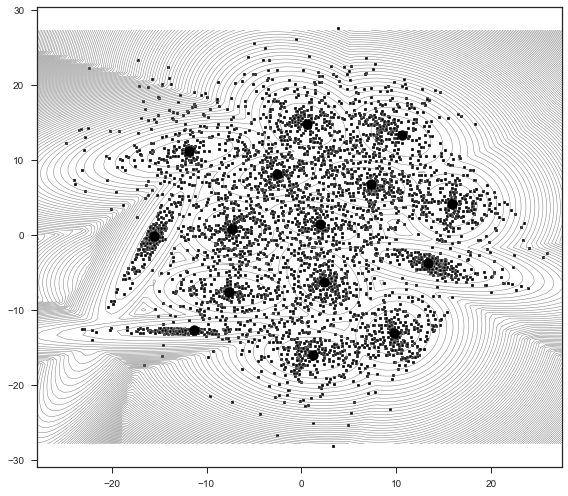

In [22]:
plt.figure(figsize=(8,7))
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.contour(DD, origin='lower', extent=extent, 
            levels=np.linspace(0.0,D.max(),100), colors='grey', linewidths=0.5)
plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)
plt.show()

### Среднее арифметическое

In [12]:
arith = avragg.ArithMean()
km = mlocation_scatter.MLocationsScattersEstimator(arith, avgmin, 15, 
                                    tol=1.0e-6, n_iter=200, n_step=400)

In [13]:
km.fit(X)

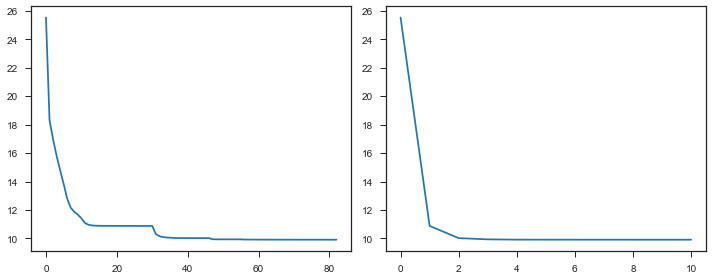

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(km.dvals)
plt.subplot(1,2,2)
plt.plot(km.dvals2)
plt.show()

In [15]:
D2 = km.evaluate_dist(XX)
DD2 = D2.reshape(XX1.shape)
print(D2.min(), D2.max())

0.001095806881973382 769.8925759343585


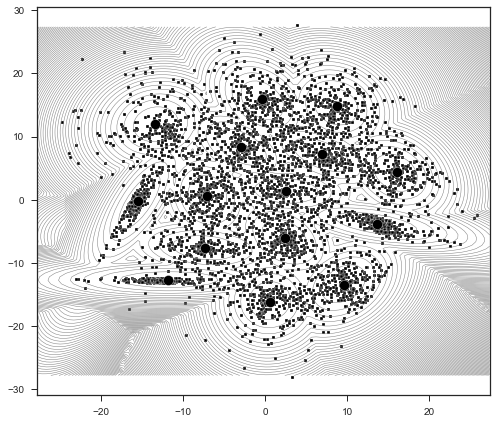

In [16]:
plt.figure(figsize=(7,6))
plt.contour(DD2, origin='lower', extent=extent, 
            levels=np.linspace(0.,D2.max(),100), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
plt.show()

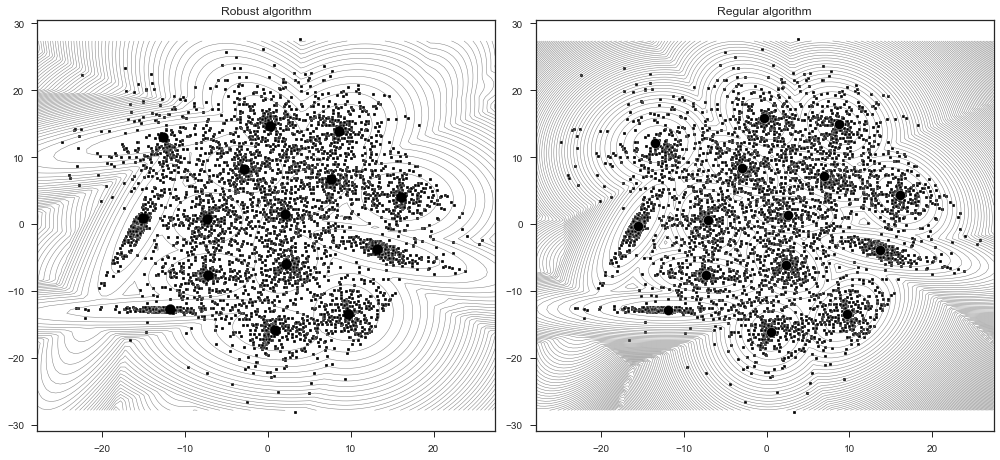

In [17]:
plt.figure(figsize=(14,6.5))

plt.subplot(1,2,1)
plt.title('Robust algorithm')
plt.contour(DD, origin='lower', extent=extent, 
            levels=np.linspace(0.,D.max(),50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)

plt.subplot(1,2,2)
plt.title('Regular algorithm')
plt.contour(DD2, origin='lower', extent=extent, 
            levels=np.linspace(0.,D2.max(),100), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
plt.savefig('fig/robust_kmeans_center_variance_s4.eps')
plt.tight_layout()
plt.show()